In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

In [2]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Multi-fidelity using SRegression

In [4]:
# Here we take an example from adapt official website.
# example from https://adapt-python.github.io/adapt/examples/Multi_fidelity.html
def low_fidelity(Xs):
    ys = (1 - Xs**2) * np.sin(2 * 2 * np.pi * Xs) - Xs
    return ys


def high_fidelity(Xt):
    yt = (1 - Xt**2) * np.sin(2 * 2 * np.pi * Xt) - Xt - 1.5
    return yt

In [5]:
x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = x_plot
x_train_h = x_plot[:100]

# For low-fidelity training data, injecting some Gaussian noise.
y_train_l = low_fidelity(x_train_l) + 0.1 * np.random.randn(len(x_train_l))[:, None]
y_train_h = high_fidelity(x_train_h)

We usually have more HF training points than the LF training points.


In [6]:
y_train_h.shape, y_train_l.shape

((100, 1), (200, 1))

Text(0.5, 1.0, 'High and low fidelity functions')

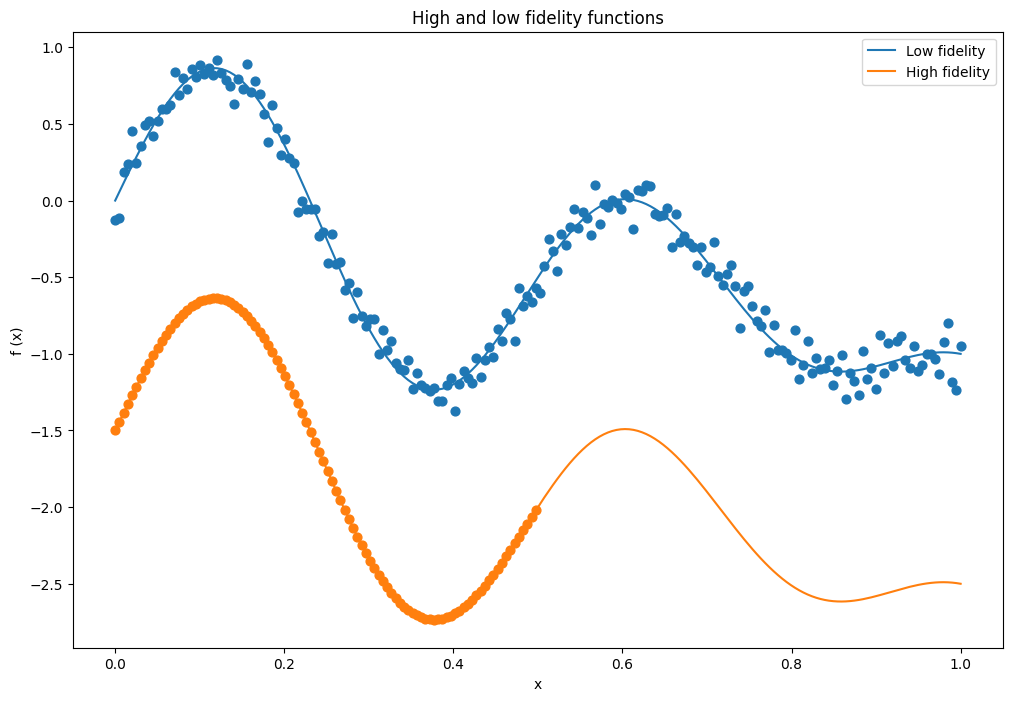

In [7]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity functions")

In [8]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    denoise=True,
)

# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "cube", "log"],
    **default_pysr_params,
)

model.fit(x_train_l, y_train_l)

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.44083914   
	1         0.000889                                  cube(-0.74973106)   
	2         0.506928                                     0.0785023 - x0   
	3         0.042513                     (-1.495773 * x0) - -0.32639375   
	4         0.910954                            sin(x0 * 12.74173) - x0   
	5         1.291298                      sin(sin(12.618287 * x0) - x0)   
	6         0.223639                 sin(sin(sin(x0 * 12.595696)) - x0)   
	7         0.370347        sin(sin(12.590961 * x0) - (1.2917466 * x0))   
	8         2.257027         (sin(x0 * 12.525079) * cube(cos(x0))) - x0   
	9   >>>>  1.652184  ((0.9926728 - square(x0)) * sin(12.514506 * x0...   
	10        0.011154  ((cos(0.098020405) - square(x0)) * sin(12.5145...   
	11        0.024729  (0.9926728 * ((cos(12.514506) - square(x0)) * ...   
	12        0.003552  (0.9926728 * ((cos(cube(-0.2691223)) - square(...   
	13        0.000155  (0.9926728 * ((cos(square(sin(12.514506))) - s...   
	14        0.164297  (sin(12.514644 * x0) * (exp(cube(cube(sin(x0))...   
	
	        loss  complexity  
	0   0.421976           1  
	1   0.421601           2  
	2   0.253949           3  
	3   0.233249           5  
	4   0.093799           6  
	5   0.025787           7  
	6   0.020619           8  
	7   0.014237           9  
	8   0.001490          10  
	9   0.000286          11  
	10  0.000282          12  
	11  0.000269          14  
	12  0.000268          15  
	13  0.000268          16  
	14  0.000227          17  
]

In [9]:
model.sympy()

-x0 + (0.9926728 - x0**2)*sin(12.514506*x0)

In [10]:
ypredict = model.predict(x_plot)
ypredict_simpler = model.predict(x_plot, 2)

print("Default selection MSE:", np.power(ypredict - y_plot_l, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y_plot_l, 2).mean())

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Default selection MSE: 0.8504320937563021
Manual selection MSE for index 2: 0.5126103485145873


Text(0.5, 1.0, 'High and low fidelity functions')

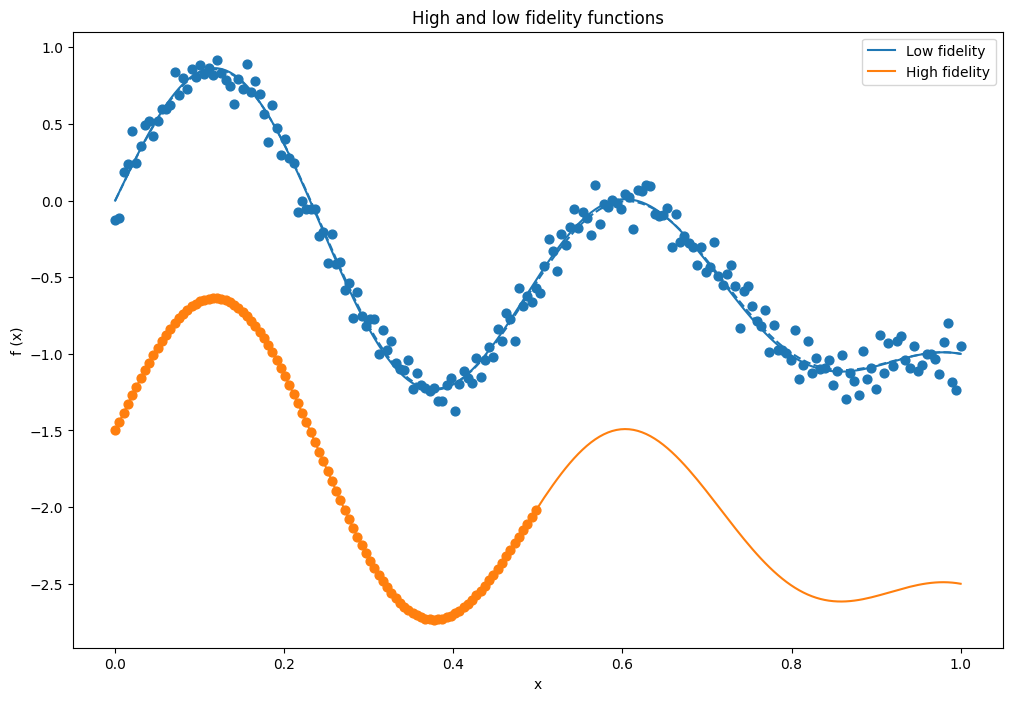

In [11]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.plot(x_plot, ypredict, "C0--")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity functions")

We can also filter all equations up to 2x the most accurate equation, then select the best score from that list:

In [12]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)

-x0 + (0.9926728 - x0**2)*sin(12.514506*x0)

## Naive multi-fidelity

Train on HF data - LF model

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


(-2.5, 1.5)

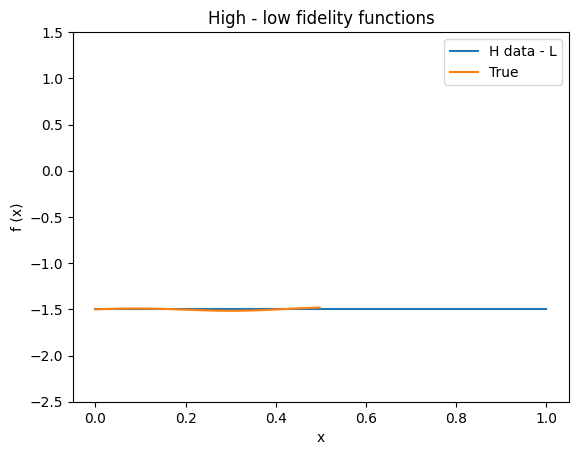

In [13]:
ypredict_h_from_l = model.predict(x_train_h)

## Plot the original functions

# plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_h - y_plot_l, "C0")
plt.plot(x_train_h, y_train_h[:, 0] - ypredict_h_from_l, "C1")
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["H data - L", "True"])
plt.title("High - low fidelity functions")
plt.ylim(-2.5, 1.5)

Ah this looks actually promising using easy functions

In [14]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    # denoise=True,
)

# Learn equations
model_mf = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "cube", "log"],
    **default_pysr_params,
)

# The difference between high and low fidelity data is the target
y_diff = y_train_h[:, 0] - ypredict_h_from_l

model_mf.fit(x_train_h, y_diff)

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[ Info: Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                                 x0   
	1         1.037779e+01                                   cube(-1.1448481)   
	2         9.386996e-07                            -2.1249933 + 0.62445754   
	3         1.350028e-01                      -1.5027554 + square(cube(x0))   
	4         4.673412e-01                  -0.511032 - cos(x0 + -0.25337288)   
	5         2.898357e-01      square(-0.092634805 + square(x0)) + -1.507644   
	6         7.069835e-03  square(-0.092634805 + square(0.0024803772 + x0...   
	7         3.755424e-01  ((-0.4513353 + x0) * square(x0)) + (2.2140718 ...   
	8         1.375450e-03  (sin(-0.4513353 + x0) * square(x0)) + (2.21407...   
	9         4.717385e-01  (1.2857144 + -2.7772026) + (square(x0 * 1.1820...   
	10        9.063213e-03  (-2.7772026 + 1.2857144) + ((-0.4537772 + x0) ...   
	11        2.422051e-03  (-2.7772026 + 1.2857144) + ((-0.4537772 + x0) ...   
	12        7.554061e-03  (-2.7772026 + 1.2857144) + ((-0.4537772 + x0) ...   
	13        5.724704e-02  (((1.2857144 + x0) - 0.15561937) * (square(x0)...   
	14  >>>>  2.818322e-01  (((-0.4537772 + x0) * square(x0 - (square(-0.2...   
	15        1.780305e-01  (cos(exp(exp(square(cube(cube(x0 * (-2.0508742...   
	16        2.256399e-02  (cos(exp(exp(square(sin(cube(cube(x0 * (-2.012...   
	
	        loss  complexity  
	0   3.081301           1  
	1   0.000096           2  
	2   0.000096           3  
	3   0.000073           5  
	4   0.000046           6  
	5   0.000034           7  
	6   0.000034           9  
	7   0.000023          10  
	8   0.000023          11  
	9   0.000014          12  
	10  0.000014          13  
	11  0.000014          14  
	12  0.000014          15  
	13  0.000013          16  
	14  0.000010          17  
	15  0.000007          19  
	16  0.000007          20  
]

In [15]:
model_mf.sympy()

(x0 - 0.4537772)*(x0 - (0.0881157250909849 - x0))**2*0.49635804 - 2.7772026 + 1.2857144

In [16]:
model_mf.sympy(1) # The second simplest model

-1.50052627016185

In [17]:
ypredict = model_mf.predict(x_plot)
ypredict_simpler = model_mf.predict(x_plot, 1)

y_diff_true = y_plot_h - y_plot_l

print("Default selection MSE:", np.power(ypredict - y_diff_true, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y_diff_true, 2).mean())

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Default selection MSE: 0.11068682951816802
Manual selection MSE for index 2: 2.7696028325365543e-07


## Test the multi-fidelity output

In [18]:
def multi_fidelity(x, complexity=1):
    """
    Multi-fidelity model that predicts the high-fidelity function.
    """
    return model.predict(x) + model_mf.predict(x, complexity)

In [19]:
y_predict_mf = multi_fidelity(x_plot, 1)

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Text(0.5, 1.0, 'High fidelity function')

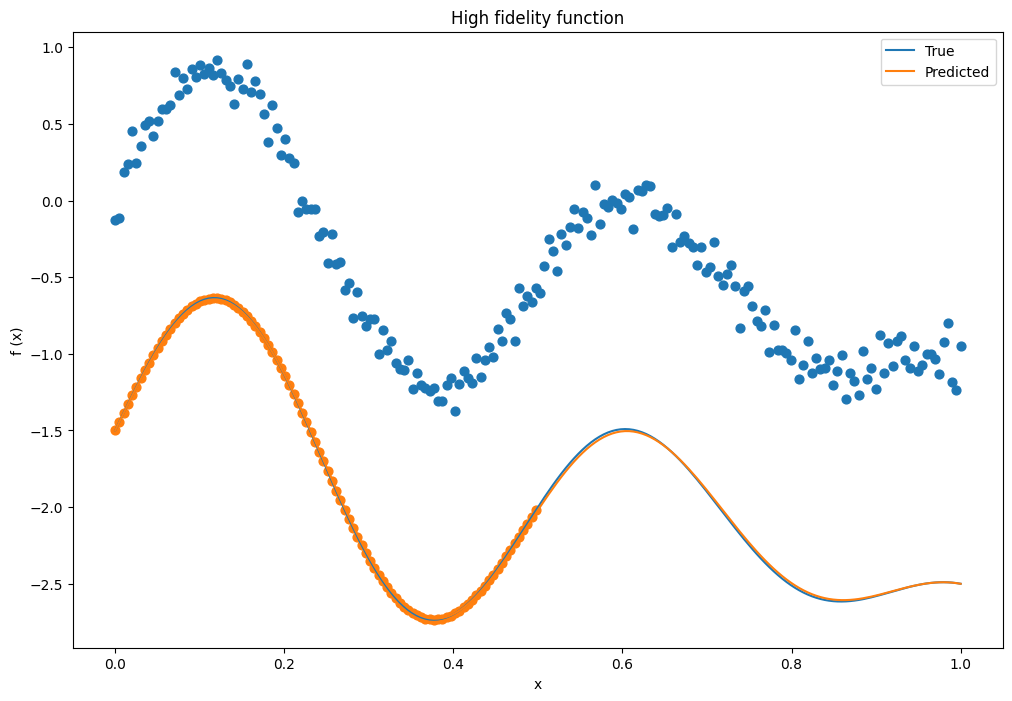

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_h, "C0")
plt.plot(x_plot, y_predict_mf, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["True", "Predicted"])
plt.title("High fidelity function")


In [27]:
x_train_h.shape, y_predict_l.shape, y_predict_mf.shape

((100, 1), (200,), (200,))

In [31]:
np.hstack([x_train_h, y_predict_l[:100][:, None]]).shape

(100, 2)

## A wrapper to do SR for multiple levels

In [32]:
class MultiFidelitySRegressor:
    """
    Multi-fidelity surrogate model that predicts the high-fidelity function.

    Parameters
    ----------
    model : PySRRegressor
        Low-fidelity model.
    model_mf : PySRRegressor
        Multi-fidelity model.
    complexity : int
        Complexity of the multi-fidelity model.
    """
    def __init__(self, model, model_mf, complexity=1):
        self.model = model
        self.model_mf = model_mf
        self.complexity = complexity

    def fit(self, x_l, y_l, x_h, y_h):
        """
        Fit the multi-fidelity model.

        Parameters
        ----------
        x_l : array-like
            Low-fidelity input data.
        y_l : array-like
            Low-fidelity target data.
        x_h : array-like
            High-fidelity input data.
        y_h : array-like
            High-fidelity target data.
        """
        # train LF model
        self.model.fit(x_l, y_l)
        # Predict LF model on HF input data
        f_l = self.model.predict(x_h)

        # Stack the LF model predictions with the HF input data
        _x_h = np.hstack([x_h, f_l[:, None]])

        self.model_mf.fit(_x_h, y_h)

    def predict(self, x):
        """
        Predict the high-fidelity function.
        """
        f_l = self.model.predict(x)
        _x = np.hstack([x, f_l[:, None]])
        return self.model_mf.predict(_x, self.complexity)

    def sympy(self):
        return self.model.sympy(), self.model_mf.sympy(self.complexity)

    def __call__(self, x):
        return self.predict(x)

    def __repr__(self):
        return f"MultiFidelitySRegressor(model={self.model}, model_mf={self.model_mf}, complexity={self.complexity})"

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[ Info: Started!
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you

Text(0.5, 1.0, 'High fidelity function')

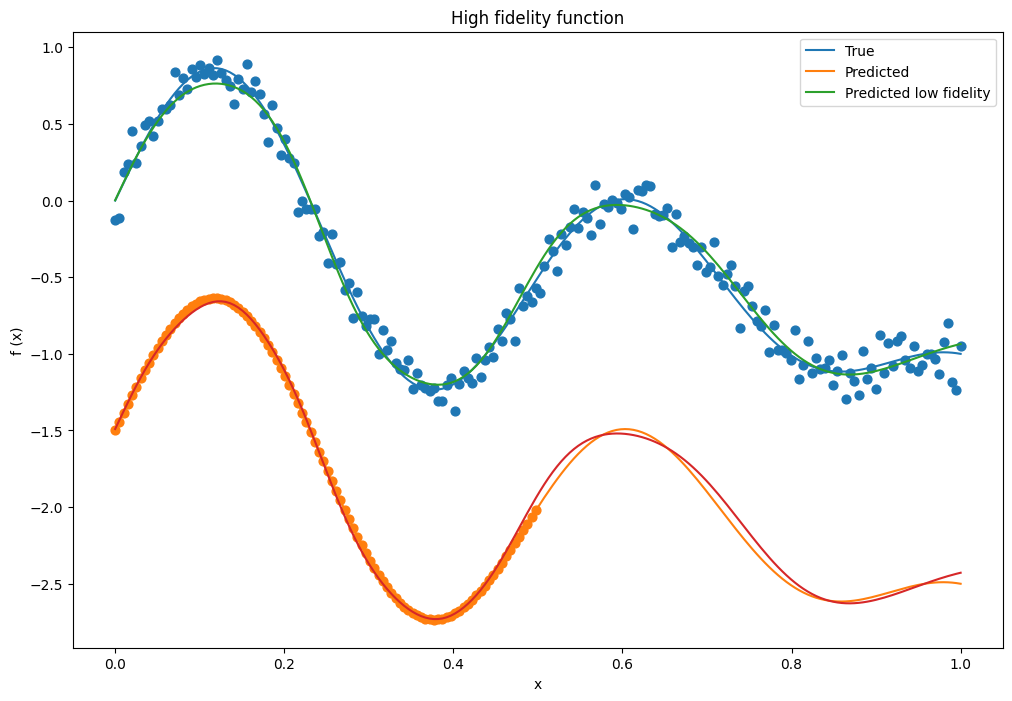

In [34]:
# Example usage
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    denoise=True,
)

model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

model_mf = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["square", "cube", "log"],
    **default_pysr_params,
)

# Fit the multi-fidelity model
model_mf_s = MultiFidelitySRegressor(model, model_mf, complexity=None)

model_mf_s.fit(x_train_l, y_train_l[:, 0], x_train_h, y_train_h[:, 0])

# Predict the high-fidelity function
y_predict_mf = model_mf_s(x_plot)
# predict the low-fidelity function
y_predict_l = model_mf_s.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.plot(x_plot, y_predict_l, "C2")
plt.plot(x_plot, y_predict_mf, "C3")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["True", "Predicted", "Predicted low fidelity"])
plt.title("High fidelity function")


In [35]:
model_mf_s.sympy()[0]

-sin(cos(exp(cos(x0) + 1.0514807))**2) + sin(cos(exp(cos(exp(x0)) + 2.103638))) - 0.060852963

In [36]:
model_mf_s.sympy()[1]

x1 + 0.216478972578011*(x0 + x1)**9 - 1.4925225